In [2]:
import cv2
import numpy as np
import os
from scipy.stats import entropy

def add_noise(image, sigma):
    row, col, ch = image.shape
    mean = 0
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = image + gauss * 255
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

def adjust_brightness_contrast(image, alpha, beta):
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def apply_filter(image, filter_type='blur'):
    if filter_type == 'blur':
        return cv2.GaussianBlur(image, (25, 25), 0)
    elif filter_type == 'edge':
        return cv2.Canny(image, 100, 200)
    elif filter_type == 'sharpen':
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        return cv2.filter2D(image, -1, kernel)

def random_rotation(image):
    angle = np.random.randint(-30, 30)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    return cv2.warpAffine(image, M, (w, h))

def process_image(image):
    # 增加更强的噪声
    noisy_image = add_noise(image, sigma=1.0)
    # 更大幅度地改变亮度和对比度
    adjusted_image = adjust_brightness_contrast(noisy_image, alpha=3.0, beta=90)
    # 应用更强的滤镜
    filtered_image = apply_filter(adjusted_image, filter_type='blur')
    # 添加随机旋转
    final_image = random_rotation(filtered_image)
    return final_image

def process_images(source_domains, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    for domain in source_domains:
        for split in ['train', 'val']:
            domain_split_path = os.path.join('../data/office_home_copy', domain, split)
            for cls in os.listdir(domain_split_path):
                class_path = os.path.join(domain_split_path, cls)
                images = os.listdir(class_path)
                save_class_path = os.path.join(save_path, domain, split, cls)
                os.makedirs(save_class_path, exist_ok=True)
                for img in images:
                    img_path = os.path.join(class_path, img)
                    image = cv2.imread(img_path)
                    
                    final_image = process_image(image)
                    
                    save_img_path = os.path.join(save_class_path, img)
                    cv2.imwrite(save_img_path, final_image)
                

# source_domains = ["clipart", "product", "real_world"]
# process_images(source_domains, save_path='../data/office_home_copy_processed')

In [12]:
def calculate_image_based_kl_divergence(source_path, target_path):
    source_features = []
    target_features = []

    for domain in os.listdir(source_path):
        for split in ['train', 'val']:
            domain_split_path = os.path.join(source_path, domain, split)
            for cls in os.listdir(domain_split_path):
                class_path = os.path.join(domain_split_path, cls)
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    img = cv2.imread(img_path)
                    # 使用更复杂的特征：颜色直方图
                    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
                    hist = hist.flatten()
                    hist /= hist.sum()
                    source_features.append(hist)
    
    for split in ['train', 'val']:
        target_domain_path = os.path.join(target_path, split)
        for cls in os.listdir(target_domain_path):
            class_path = os.path.join(target_domain_path, cls)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
                hist = hist.flatten()
                hist /= hist.sum()
                target_features.append(hist)

    # 计算平均特征
    source_mean = np.mean(source_features, axis=0)
    target_mean = np.mean(target_features, axis=0)

    # 避免除以零
    source_mean += 1e-10
    target_mean += 1e-10

    # 归一化
    source_mean /= np.sum(source_mean)
    target_mean /= np.sum(target_mean)

    return entropy(target_mean, source_mean)

# 计算处理前后的KL散度
kl_before = calculate_image_based_kl_divergence('../data/office_home_noart', '../data/office_home_copy/art')
kl_after = calculate_image_based_kl_divergence('../data/office_home_copy_processed', '../data/office_home_copy/art')

print(f"KL Divergence before processing: {kl_before}")
print(f"KL Divergence after processing: {kl_after}")

KL Divergence before processing: 0.24163800477981567
KL Divergence after processing: 3.050083637237549


In [17]:
def calculate_RGB_image_based_kl_divergence(source_path, target_path):
    source_features = []
    target_features = []

    for domain in os.listdir(source_path):
        for split in ['train', 'val']:
            domain_split_path = os.path.join(source_path, domain, split)
            for cls in os.listdir(domain_split_path):
                class_path = os.path.join(domain_split_path, cls)
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    feature = np.mean(img)  # 使用平均像素值作为特征
                    source_features.append(feature)
    
    for split in ['train', 'val']:
        target_domain_path = os.path.join(target_path, split)
        for cls in os.listdir(target_domain_path):
            class_path = os.path.join(target_domain_path, cls)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                feature = np.mean(img)
                target_features.append(feature)

    # 将特征值转换为概率分布
    source_hist, _ = np.histogram(source_features, bins=50, density=True)
    target_hist, _ = np.histogram(target_features, bins=50, density=True)

    # 避免除以零
    source_hist += 1e-10
    target_hist += 1e-10

    # 归一化
    source_hist /= np.sum(source_hist)
    target_hist /= np.sum(target_hist)

    return entropy(target_hist, source_hist)

kl_before_mean = calculate_RGB_image_based_kl_divergence('../data/office_home_noart', '../data/office_home_copy/art')
kl_after_mean = calculate_RGB_image_based_kl_divergence('../data/office_home_copy_processed', '../data/office_home_copy/art')
print(f"KL Divergence before processing: {kl_before_mean}")
print(f"KL Divergence after processing: {kl_after_mean}")


KL Divergence before processing: 0.2688905049214957
KL Divergence after processing: 0.11259286862131096


Number of source images: 13161
Number of target images: 2427
Number of source images: 13161
Number of target images: 2427
Number of source images: 13161
Number of target images: 2427
Number of source images: 13161
Number of target images: 2427
KL Divergence (Mean Pixel Value): 0.281099857506048
KL Divergence (Color Histogram): 0.24163812398910522
KL Divergence (Mean Pixel Value): 0.11016572653327025
KL Divergence (Color Histogram): 4.4528069496154785


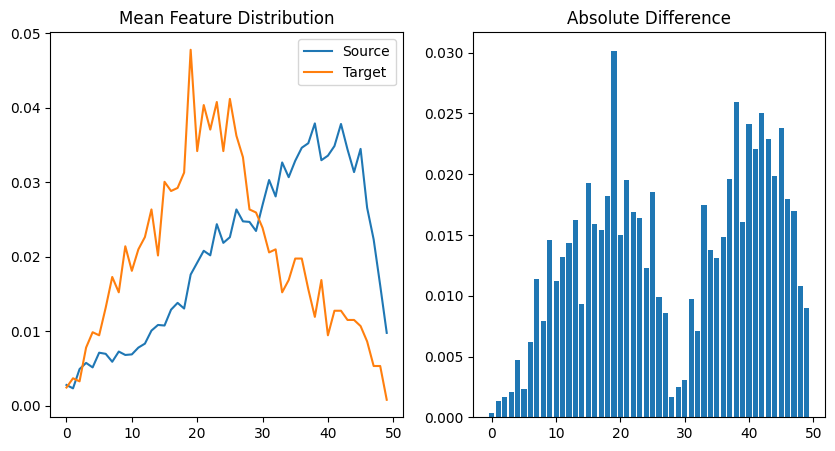

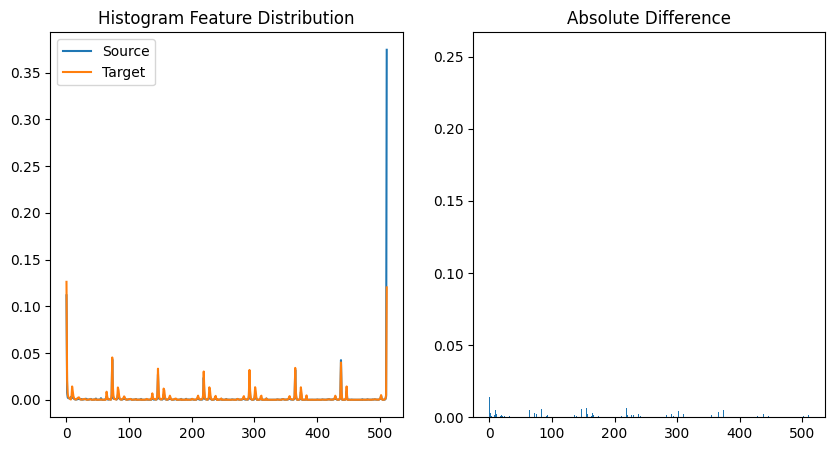

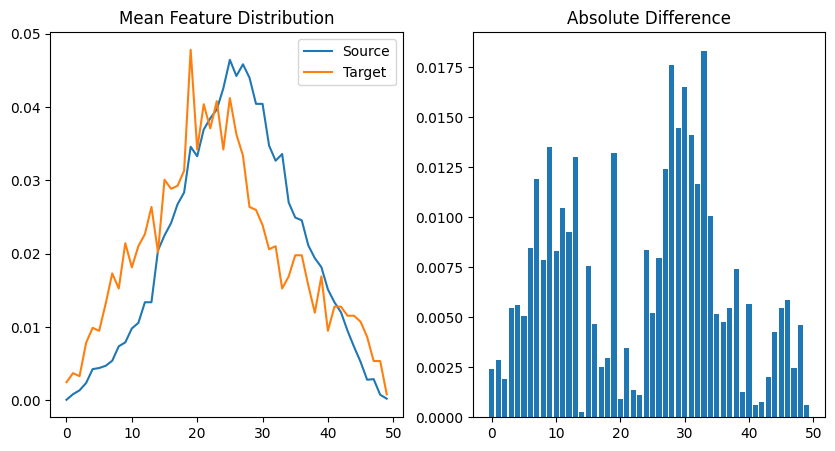

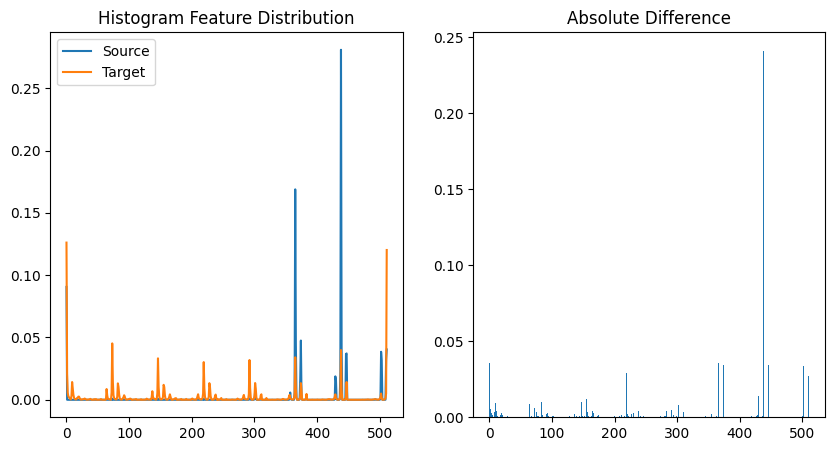

In [27]:
import numpy as np
import cv2
import os
from scipy.stats import entropy
import matplotlib.pyplot as plt

def calculate_kl_divergence(source_path, target_path, feature_type='mean'):
    def extract_features(path):
        features = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(root, file)
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Warning: Could not read image {img_path}")
                        continue
                    if feature_type == 'mean':
                        feature = np.mean(img)
                    elif feature_type == 'histogram':
                        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
                        feature = hist.flatten() / hist.sum()
                    features.append(feature)
        return np.array(features)

    source_features = extract_features(source_path)
    target_features = extract_features(target_path)

    print(f"Number of source images: {len(source_features)}")
    print(f"Number of target images: {len(target_features)}")

    if feature_type == 'mean':
        source_hist, _ = np.histogram(source_features, bins=50, density=True)
        target_hist, _ = np.histogram(target_features, bins=50, density=True)
    else:
        source_hist = np.mean(source_features, axis=0)
        target_hist = np.mean(target_features, axis=0)

    source_hist = np.clip(source_hist, 1e-10, None)
    target_hist = np.clip(target_hist, 1e-10, None)

    source_hist /= np.sum(source_hist)
    target_hist /= np.sum(target_hist)

    kl_div = entropy(target_hist, source_hist)

    # 可视化分布
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(source_hist, label='Source')
    plt.plot(target_hist, label='Target')
    plt.legend()
    plt.title(f'{feature_type.capitalize()} Feature Distribution')
    plt.subplot(1, 2, 2)
    plt.bar(range(len(source_hist)), np.abs(source_hist - target_hist))
    plt.title('Absolute Difference')
    plt.savefig(f'{feature_type}_distribution.png')

    return kl_div

# 计算并比较两种方法的KL散度
kl_original_mean = calculate_kl_divergence('../data/office_home_noart', '../data/office_home_copy/art', 'mean')
kl_original_hist = calculate_kl_divergence('../data/office_home_noart', '../data/office_home_copy/art', 'histogram')
kl_mean = calculate_kl_divergence('../data/office_home_copy_processed', '../data/office_home_copy/art', 'mean')
kl_hist = calculate_kl_divergence('../data/office_home_copy_processed', '../data/office_home_copy/art', 'histogram')

print(f"KL Divergence (Mean Pixel Value): {kl_original_mean}")
print(f"KL Divergence (Color Histogram): {kl_original_hist}")
print(f"KL Divergence (Mean Pixel Value): {kl_mean}")
print(f"KL Divergence (Color Histogram): {kl_hist}")

Number of target images: 2427
Number of source images in real_world: 4357
KL Divergence for real_world: 0.08780442970250071
Number of source images in clipart: 4365
KL Divergence for clipart: 0.05595744059443954
Number of source images in product: 4439
KL Divergence for product: 0.1682023406511607
Number of target images: 2427
Number of source images in real_world: 4357
KL Divergence for real_world: 4.67590856552124
Number of source images in clipart: 4365
KL Divergence for clipart: 4.305699348449707
Number of source images in product: 4439
KL Divergence for product: 4.80624532699585
Average KL Divergence (Mean Pixel Value): 0.10398807031603365
KL Divergences for each domain (Mean Pixel Value): [0.08780442970250071, 0.05595744059443954, 0.1682023406511607]
Average KL Divergence (Color Histogram): 4.595951080322266
KL Divergences for each domain (Color Histogram): [4.6759086, 4.3056993, 4.8062453]


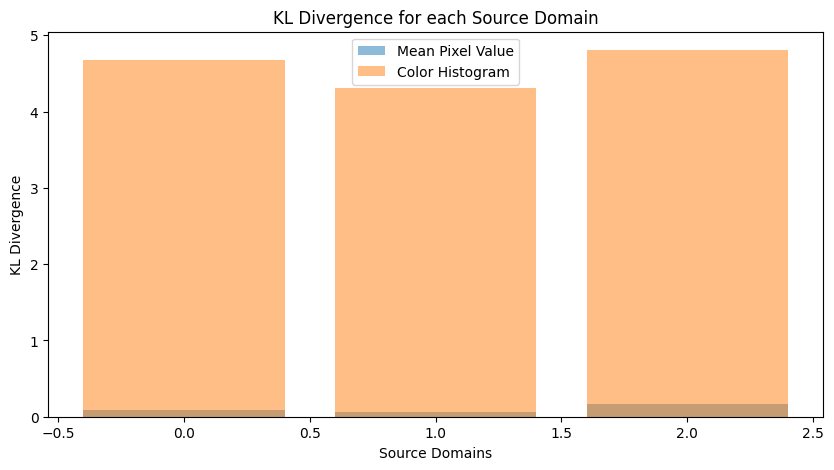

In [26]:
import numpy as np
import cv2
import os
from scipy.stats import entropy
import matplotlib.pyplot as plt

def calculate_kl_divergence(source_path, target_path, feature_type='mean'):
    def extract_features(path):
        features = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(root, file)
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Warning: Could not read image {img_path}")
                        continue
                    if feature_type == 'mean':
                        feature = np.mean(img)
                    elif feature_type == 'histogram':
                        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
                        feature = hist.flatten() / hist.sum()
                    features.append(feature)
        return np.array(features)
    
    def calc_kl_div(source_features, target_features):
        if feature_type == 'mean':
            source_hist, _ = np.histogram(source_features, bins=50, density=True)
            target_hist, _ = np.histogram(target_features, bins=50, density=True)
        else:
            source_hist = np.mean(source_features, axis=0)
            target_hist = np.mean(target_features, axis=0)

        source_hist = np.clip(source_hist, 1e-10, None)
        target_hist = np.clip(target_hist, 1e-10, None)

        source_hist /= np.sum(source_hist)
        target_hist /= np.sum(target_hist)

        return entropy(target_hist, source_hist)

    target_features = extract_features(target_path)
    print(f"Number of target images: {len(target_features)}")

    kl_divs = []
    for domain in os.listdir(source_path):
        domain_path = os.path.join(source_path, domain)
        if os.path.isdir(domain_path):
            source_features = extract_features(domain_path)
            print(f"Number of source images in {domain}: {len(source_features)}")
            kl_div = calc_kl_div(source_features, target_features)
            kl_divs.append(kl_div)
            print(f"KL Divergence for {domain}: {kl_div}")

    avg_kl_div = np.mean(kl_divs)
    return avg_kl_div, kl_divs

# 计算并比较两种方法的KL散度
avg_kl_mean, kl_means = calculate_kl_divergence('../data/office_home_copy_processed', '../data/office_home_copy/art', 'mean')
avg_kl_hist, kl_hists = calculate_kl_divergence('../data/office_home_copy_processed', '../data/office_home_copy/art', 'histogram')

print(f"Average KL Divergence (Mean Pixel Value): {avg_kl_mean}")
print(f"KL Divergences for each domain (Mean Pixel Value): {kl_means}")
print(f"Average KL Divergence (Color Histogram): {avg_kl_hist}")
print(f"KL Divergences for each domain (Color Histogram): {kl_hists}")

# 可视化每个domain的KL散度
plt.figure(figsize=(10, 5))
plt.bar(range(len(kl_means)), kl_means, alpha=0.5, label='Mean Pixel Value')
plt.bar(range(len(kl_hists)), kl_hists, alpha=0.5, label='Color Histogram')
plt.xlabel('Source Domains')
plt.ylabel('KL Divergence')
plt.title('KL Divergence for each Source Domain')
plt.legend()
plt.savefig('kl_divergences.png')

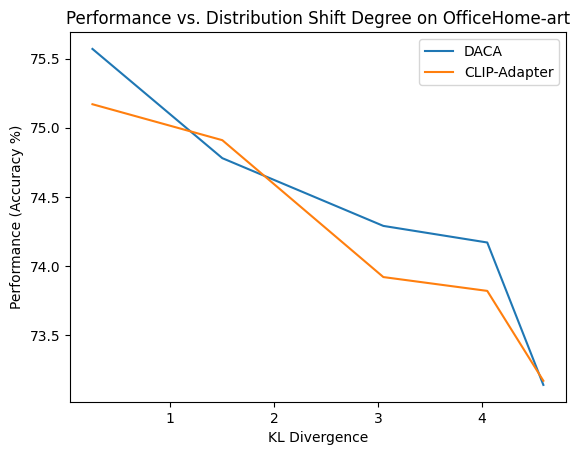

In [29]:
import matplotlib.pyplot as plt

kl_divergences = [0.25, 1.50, 3.05, 4.05, 4.59] 
performances = {
    'DACA': [75.57, 74.78, 74.29, 74.17, 73.14],
    'CLIP-Adapter': [75.17, 74.91, 73.92, 73.82, 73.17]
}

for model, perf in performances.items():
    plt.plot(kl_divergences, perf, label=model)

plt.xlabel('KL Divergence')
plt.ylabel('Performance (Accuracy %)')
plt.title('Performance vs. Distribution Shift Degree on OfficeHome-art')
plt.legend()
plt.show()


In [10]:
import os
import shutil
import random
import numpy as np
import cv2
from scipy.stats import entropy

def subsample_and_process_images(source_domains, target_domain, save_path, sample_ratio=0.5, num_subsets=5):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    for subset in range(num_subsets):
        subset_path = os.path.join(save_path, f'subset_{subset}')
        os.makedirs(subset_path, exist_ok=True)
        
        for domain in source_domains:
            domain_path = os.path.join('../data/office_home_copy', domain)
            for split in ['train', 'val']:
                split_path = os.path.join(domain_path, split)
                for cls in os.listdir(split_path):
                    class_path = os.path.join(split_path, cls)
                    images = os.listdir(class_path)
                    
                    sampled_images = random.sample(images, int(len(images) * sample_ratio))
                    
                    save_class_path = os.path.join(subset_path, domain, split, cls)
                    os.makedirs(save_class_path, exist_ok=True)
                    
                    for img in sampled_images:
                        img_path = os.path.join(class_path, img)
                        image = cv2.imread(img_path)
                        
                        processed_image = process_image(image)
                        
                        save_img_path = os.path.join(save_class_path, img)
                        cv2.imwrite(save_img_path, processed_image)

def process_image(image):
    # 增加噪声
    noisy_image = add_noise(image, sigma=1.0)
    # 改变亮度和对比度
    adjusted_image = adjust_brightness_contrast(noisy_image, alpha=3.0, beta=80)
    # 应用滤镜
    filtered_image = apply_filter(adjusted_image, filter_type='sharpen')
    # 添加随机旋转
    final_image = random_rotation(filtered_image)
    return final_image

# 主程序
source_domains = ["clipart", "product", "real_world"]
target_domain = "art"
save_path = '../data/office_home_subsampled'

# 生成子采样数据集
subsample_and_process_images(source_domains, target_domain, save_path, sample_ratio=0.1, num_subsets=1)

In [11]:
import numpy as np
import cv2
import os
from scipy.stats import entropy
import matplotlib.pyplot as plt

def calculate_kl_divergence(source_path, target_path, feature_type='mean'):
    def extract_features(path):
        features = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(root, file)
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Warning: Could not read image {img_path}")
                        continue
                    if feature_type == 'mean':
                        feature = np.mean(img)
                    elif feature_type == 'histogram':
                        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
                        feature = hist.flatten() / hist.sum()
                    features.append(feature)
        return np.array(features)

    source_features = extract_features(source_path)
    target_features = extract_features(target_path)

    print(f"Number of source images: {len(source_features)}")
    print(f"Number of target images: {len(target_features)}")

    if feature_type == 'mean':
        source_hist, _ = np.histogram(source_features, bins=50, density=True)
        target_hist, _ = np.histogram(target_features, bins=50, density=True)
    else:
        source_hist = np.mean(source_features, axis=0)
        target_hist = np.mean(target_features, axis=0)

    source_hist = np.clip(source_hist, 1e-10, None)
    target_hist = np.clip(target_hist, 1e-10, None)

    source_hist /= np.sum(source_hist)
    target_hist /= np.sum(target_hist)

    kl_div = entropy(target_hist, source_hist)

    return kl_div

# 计算并比较两种方法的KL散度
kl_mean = calculate_kl_divergence('../data/office_home_subsampled/subset_0', '../data/office_home_copy/art', 'mean')
kl_hist = calculate_kl_divergence('../data/office_home_subsampled/subset_0', '../data/office_home_copy/art', 'histogram')

print(f"  KL Divergence (Mean Pixel Value): {kl_mean}")
print(f"  KL Divergence (Color Histogram): {kl_hist}")

Number of source images: 1114
Number of target images: 2427
Number of source images: 1114
Number of target images: 2427
  KL Divergence (Mean Pixel Value): 0.1605542941857887
  KL Divergence (Color Histogram): 0.7171539664268494
